In [19]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops_table
from skimage.segmentation import find_boundaries, mark_boundaries
import pandas as pd

from glob import glob

from stardist.models import StarDist2D 
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

In [3]:
# Separate the individual stains from the IHC image
def color_separate(ihc_rgb):

    #Convert the RGB image to HED using the prebuilt skimage method
    ihc_hed = rgb2hed(ihc_rgb)
    
    # Create an RGB image for each of the separated stains
    #Convert them to ubyte for easy saving to drive as an image
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1)))

    #Optional fun exercise of combining H and DAB stains into a single image with fluorescence look
    
    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                          in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)))

# Cast the two channels into an RGB image, as the blue and green channels
#Convert to ubyte for easy saving as image to local drive
    zdh = img_as_ubyte(np.dstack((null, d, h))) #DAB in green and H in Blue

    return (ihc_h, ihc_e, ihc_d, zdh)

In [4]:
# prints a list of available models 
StarDist2D.from_pretrained()
# Define a pretrained model to segment nuclei in fluorescence images (download from pretrained)
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [5]:
img_dir = "../data/morphology_data/"
images = glob(img_dir+"*tif")
# new_img="L10-1 Cryo Exp 16 ms Gain 1 Satur 100 WB.tif"
# ihc_rgb=io.imread(new_img)

ANALYSIS

Text(0.5, 1.0, 'D image')

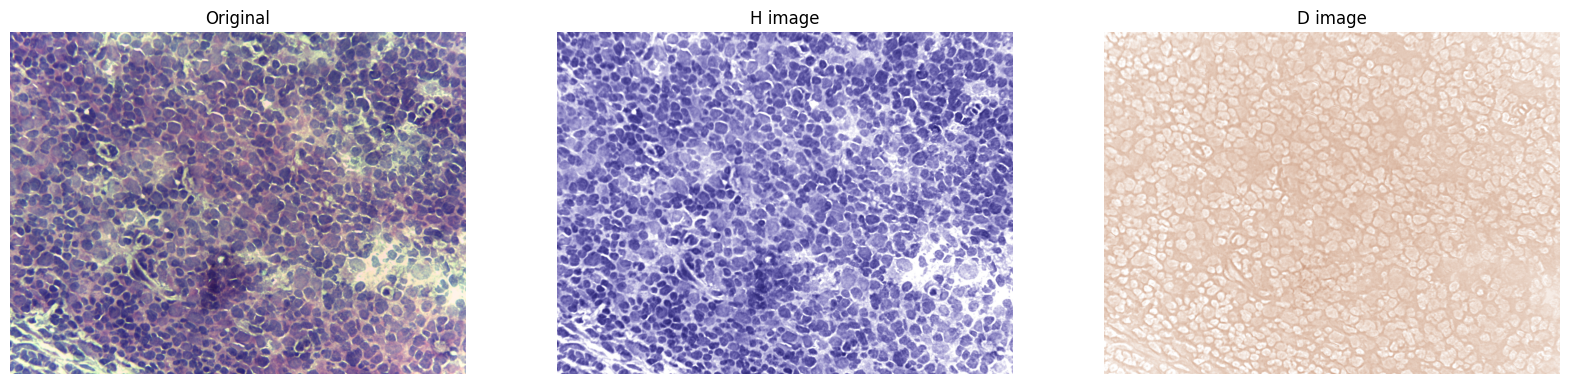

In [14]:
img = images[0]
ihc_rgb=io.imread(img)
# ihc_rgb = ihc_rgb[:int(ihc_rgb.shape[0]/3), :int(ihc_rgb.shape[1]/3), :]
H,E,D,HD = color_separate(ihc_rgb)
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(ihc_rgb)
plt.axis("off")
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(H)
plt.axis("off")
plt.title("H image")

plt.subplot(1,3,3)
plt.imshow(D)
plt.axis("off")
plt.title("D image")

Text(0.5, 1.0, 'D image')

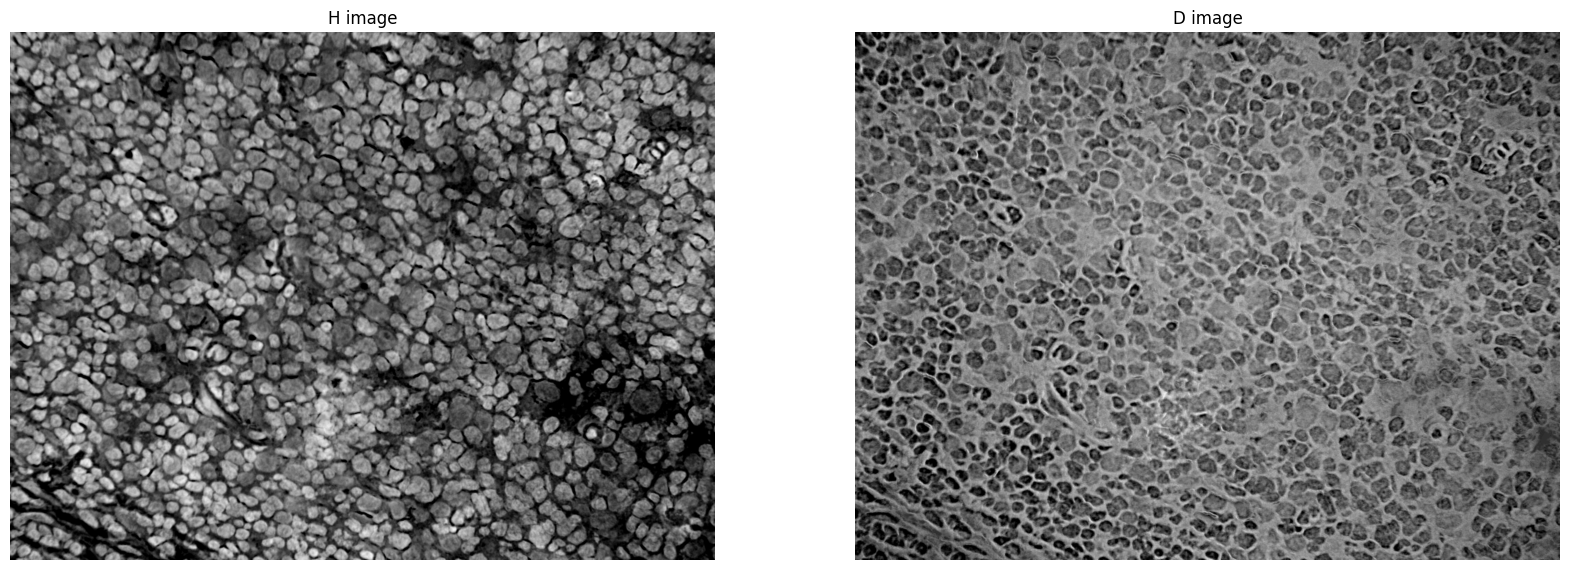

In [7]:
H_img = np.invert(H[:,:,2])
D_img = np.invert(D[:,:,2])
#plt.imshow(D_img, cmap='gray')

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(H_img, cmap='gray')
plt.axis("off")
plt.title("H image")

plt.subplot(1,2,2)
plt.imshow(D_img, cmap='gray')
plt.axis("off")
plt.title("D image")

In [8]:
D_labels, D_details = model.predict_instances(normalize(D_img))
H_labels, H_details = model.predict_instances(normalize(H_img))

1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'input+boundaries')

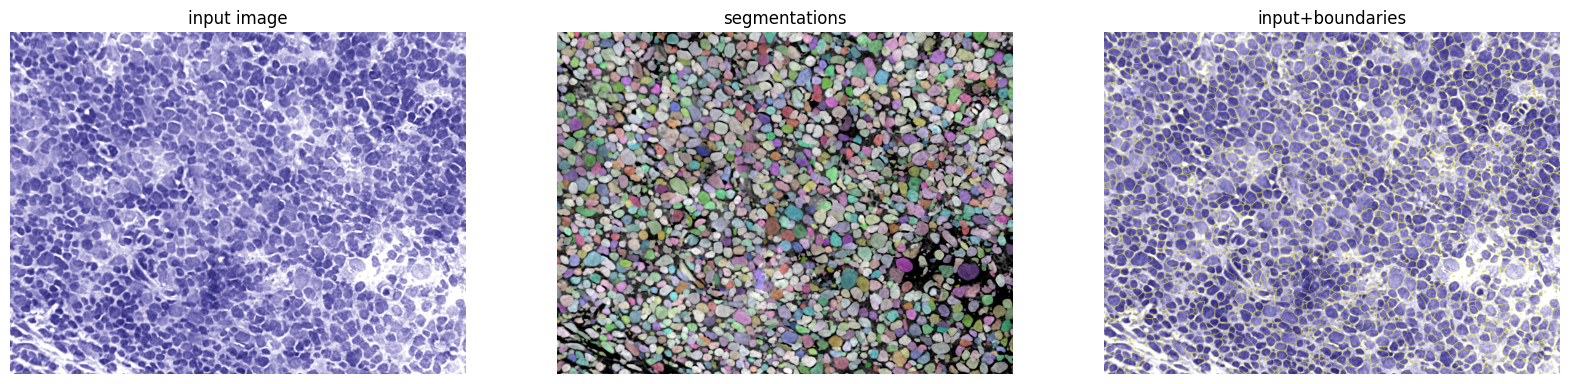

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(H)
plt.axis("off")
plt.title("input image")

plt.subplot(1,3,2)
plt.imshow(render_label(H_labels, img=H_img))
plt.axis("off")
plt.title("segmentations")

plt.subplot(1,3,3)
plt.imshow(mark_boundaries(H, H_labels))
plt.axis("off")
plt.title("input+boundaries")

In [10]:
H_props = regionprops_table(H_labels, H_img, 
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])

H_analysis_results = pd.DataFrame(H_props)
H_analysis_results.head()

,label,area,equivalent_diameter,mean_intensity,solidity
0,1,1379,41.902235,55.852792,0.958304
1,2,1377,41.871838,67.797386,0.977983
2,3,1417,42.475645,72.398024,0.969884
3,4,2044,51.014720,79.022994,0.976589
4,5,2667,58.272891,60.667042,0.977281


In [48]:
H_mean_analysis_results = H_analysis_results.describe()
H_mean_analysis_results

,label,area,equivalent_diameter,mean_intensity,solidity
count,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000
mean,1229.500000,882.604963,30.795655,61.473537,0.945164
std,709.707804,719.184477,13.246379,21.886082,0.040687
min,1.000000,33.000000,6.482045,9.323077,0.666667
25%,615.250000,299.250000,19.519650,44.240868,0.937008
50%,1229.500000,716.000000,30.193361,63.493341,0.959016
75%,1843.750000,1286.750000,40.476424,79.024072,0.970321
max,2458.000000,5813.000000,86.031049,116.474649,1.000000


SEGMENT ALL DATA

In [57]:
stats = pd.DataFrame(columns = ['type', 'name', 'N cells', 'average_area', 'average_intensity', 'average_equaivalent_diameter'])
for img in images:
    ihc_rgb=io.imread(img)
    H,E,D,HD = color_separate(ihc_rgb)
    H_img = np.invert(H[:,:,2])
    H_labels, H_details = model.predict_instances(normalize(H_img))
    marked = mark_boundaries(ihc_rgb, H_labels, color=(1,0,0))
    fname = 'ML_predicted/'+img.split('\\')[1][:-4]+"_SEGMENTED.jpeg"
    io.imsave(fname, marked, quality = 100)
    H_props = regionprops_table(H_labels, H_img, 
                          properties=['label',
                                      'area', 'equivalent_diameter',
                                      'mean_intensity', 'solidity'])
    H_analysis_results = pd.DataFrame(H_props).describe()
    exp_type = 'Cryo' if 'Cryo' in fname else 'FFPE'
    img_name = img.split('\\')[1][:-4]
    n_cells = H_analysis_results.loc['count'][0]
    ave_area = H_analysis_results.loc['mean'][1]
    ave_ave_intensity = H_analysis_results.loc['mean'][3]
    ave_eq_diam = H_analysis_results.loc['mean'][2]
    stats.loc[stats.shape[0]] = [exp_type, img_name, n_cells,
                                ave_area, 
                                ave_ave_intensity,
                                ave_eq_diam]
    # break
stats.to_csv('ML_predicted/'+'stats.csv', index=False)

1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 3s 3s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 5s 5s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 5s 5s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 5s 5s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 3s 3s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


1/1 [==============================] - 4s 4s/step


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
